In [1]:
import tensorflow as tf
import numpy as np
from parana.Model import Model
from parana.Layers import fc_layer
from parana.Layers import softmax_layer
from parana.optimizer import optimizer
from parana.optimizer import adamopt
from parana.Layers import conv_layer
from parana.parameter_saver import saver
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=False)
import pickle

path = 'path'
class this_model(Model):
    
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        self.cost_function = 'cross_entropy_l2'
        self.logit_cost_function = 'quadratic_l2'
        self.dropout = 0
        self.layers = [conv_layer(inputs = inputs + noise,
                                 height = 7, 
                                 width = 7, 
                                 filters = 12, 
                                 padding = 4, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001)]
        self.layers.append(conv_layer(inputs = self.layers[0].activate,
                                 height = 5, 
                                 width = 5, 
                                 filters = 15, 
                                 padding = 2, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(conv_layer(inputs = self.layers[1].activate,
                                 height = 3, 
                                 width = 3, 
                                 filters = 25, 
                                 padding = 1, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(conv_layer(inputs = self.layers[2].activate,
                                 height = 3, 
                                 width = 3, 
                                 filters = 20, 
                                 padding = 1, 
                                 stride = 1,
                                 flatten = True,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs = self.layers[3].activate,
                                   size = 1500,
                                   weight_init = 'xavier',
                                   weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs=self.layers[4].activate, 
                               weight_init = 'xavier',
                               size=500, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(softmax_layer(inputs=self.layers[5].activate, 
                                          size=10, 
                                          weight_decay=0.0001, bias_decay=0.0001))

X = tf.placeholder('float', [None, 28, 28, 1], name = 'Inputs')
y = tf.placeholder('float', [None, 10], name = 'Labels')   

# Limit on the intensity/strength of noise
noise_limit = 0.35
# Tensorflow assignments and functions
noise = tf.Variable(tf.random_uniform([28,28,1], 0, 0.1), name='x_noise')
set_zero_noise = tf.assign(noise, tf.zeros([28,28,1]))
noise_placeholder = tf.placeholder('float', [28, 28,1], name = 'noise_placeholder')
assign_noise = tf.assign(noise, noise_placeholder)
X_noise = X + noise
X_noise = tf.clip_by_value(X_noise, 0.0, 1.0)
x_noise_clip = tf.assign(noise, tf.clip_by_value(noise, -noise_limit, noise_limit))

sess = tf.Session()

mymodel = this_model(X_noise, y)

noise_opt = optimizer(sess, 0.1, mymodel.cost, model =  mymodel, variables_list = noise)

model_saver = saver(mymodel, sess)

sess.run(tf.global_variables_initializer())

C:\Users\Jim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
sess.run(set_zero_noise)
model_saver.load_parameters('model.p'.format(path))
print(model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))

Parameters loaded from  c:/users/jim/tensorflowtrials/cnn99.23%SCE.p
0.9923847734928131


In [3]:
path = 'path'

# Loop over noise_opt and pickle each noise file
for adversary_class in range(10):
    for i in range(5000):
        batch = mnist.train.next_batch(250)
        #Set labels to zero then target class to 1
        adv_labels = np.zeros_like(batch[1])
        adv_labels[:, adversary_class] = 1.0
        batch = (batch[0], adv_labels)
        noise_opt.min_step(data = {X:batch[0], y:batch[1]})
        sess.run(x_noise_clip)
    noisevector = sess.run(noise)
    #pickle.dump(noisevector, open('{}adv_class_{}_limit_{}.p'.format(path, adversary_class, noise_limit), 'wb'))
    print('Test Accuracy for class {}'.format(adversary_class),model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))
    #reset the noise vector
    sess.run(set_zero_noise)
print('Test Accuracy with no noise',model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))

Test Accuracy for class 0 0.5045090153813362
Test Accuracy for class 1 0.3921843692660332
Test Accuracy for class 2 0.25450901612639426
Test Accuracy for class 3 0.6919839680194855
Test Accuracy for class 4 0.40460922122001647
Test Accuracy for class 5 0.30370741710066795
Test Accuracy for class 6 0.40691382735967635
Test Accuracy for class 7 0.3122244507074356
Test Accuracy for class 8 0.37685371190309525
Test Accuracy for class 9 0.37224448621273043
Test Accuracy with no noise 0.9923847734928131


In [6]:
file_list = ['{}adv_class_0_limit_0.35.p', '{}adv_class_1_limit_0.35.p', '{}adv_class_2_limit_0.35.p', 
             '{}adv_class_3_limit_0.35.p', '{}adv_class_4_limit_0.35.p', '{}adv_class_5_limit_0.35.p',
             '{}adv_class_6_limit_0.35.p', '{}adv_class_7_limit_0.35.p', '{}adv_class_8_limit_0.35.p', 
             '{}adv_class_9_limit_0.35.p']


In [7]:
path = 'path'
vector_list = [pickle.load(open(i.format(path), 'rb')) for i in file_list]

accuracy_list = []

for i in vector_list:
    accuracy = model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images + i, 
                       labels = mnist.test.labels)
    accuracy_list.append(accuracy)
print(accuracy_list)

[0.5964929893612861, 0.5155310615897178, 0.41092184334993365, 0.27254509180784225, 0.48777554631233216, 0.14298597164452076, 0.3859719425439835, 0.35511022210121157, 0.5173346653580666, 0.5662324666976929]


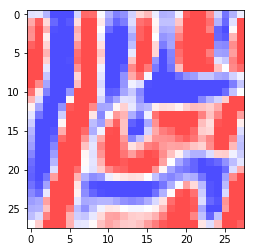

In [8]:
%matplotlib inline
import numpy as np
import pickle
import matplotlib.pyplot as plt
path = 'path'
noisevector = pickle.load(open('{}adv_class_6_limit_0.35.p'.format(path), 'rb'))
def plot_noise():
    plt.imshow(np.reshape(noisevector, (28, 28)), interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)
plot_noise()